In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'WCH.DE'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2014-03-31,1157,-993,164,64,359,699,674,2019,0,...,6589,330,0,290,1326,1158,4462,149,0,49.0
1,2014-06-30,1242,-1008,234,29,348,742,690,2076,0,...,6616,318,0,318,1227,1140,4575,110,0,49.0
2,2014-09-30,1232,-996,237,119,448,750,744,2303,0,...,7046,365,0,293,1295,1300,4957,194,0,49.0
3,2014-12-31,1195,-986,209,-17,326,684,734,2093,0,...,6947,375,0,263,1165,1318,5025,33,0,49.0
4,2015-03-31,1335,-1043,292,71,251,827,795,2150,0,...,7431,433,0,226,1288,1357,5641,163,0,49.0


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2022-12-31,2023-02-11,49.7,1826,-1467,359,229,895,916,1656,...,213,9401,886,0,461,1927,1086,4371,213,-185
36,2023-03-31,2023-04-21,49.7,1744,-1412,332,147,1324,988,1645,...,207,9594,838,0,452,1931,1180,4476,190,-141
37,2023-06-30,2023-07-21,49.7,1753,-1430,323,119,812,924,1527,...,307,8712,774,0,437,1657,1089,4262,162,-130
38,2023-09-30,2023-10-21,49.7,1523,-1325,198,34,935,879,1455,...,308,8812,754,0,443,1692,1095,4071,275,-147
39,2023-12-31,2024-02-11,49.7,1382,-1152,230,27,1013,788,1449,...,293,8854,879,0,418,1763,1088,4275,309,-221


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,49.7,1826,-1467,359,229,895,916,1656,...,9401,886,0,461,1927,1086,4371,213,-185,0.980663
36,2023-03-31,2023-04-21,49.7,1744,-1412,332,147,1324,988,1645,...,9594,838,0,452,1931,1180,4476,190,-141,0.932003
37,2023-06-30,2023-07-21,49.7,1753,-1430,323,119,812,924,1527,...,8712,774,0,437,1657,1089,4262,162,-130,0.918362
38,2023-09-30,2023-10-21,49.7,1523,-1325,198,34,935,879,1455,...,8812,754,0,443,1692,1095,4071,275,-147,0.918837
39,2023-12-31,2024-02-11,49.7,1382,-1152,230,27,1013,788,1449,...,8854,879,0,418,1763,1088,4275,309,-221,0.929674


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,49.7,1826,-1467,359,229,895,916,1656,...,9401,886,0,461,1927,1086,4371,213,-185,0.980663
36,2023-03-31,2023-04-21,49.7,1744,-1412,332,147,1324,988,1645,...,9594,838,0,452,1931,1180,4476,190,-141,0.932003
37,2023-06-30,2023-07-21,49.7,1753,-1430,323,119,812,924,1527,...,8712,774,0,437,1657,1089,4262,162,-130,0.918362
38,2023-09-30,2023-10-21,49.7,1523,-1325,198,34,935,879,1455,...,8812,754,0,443,1692,1095,4071,275,-147,0.918837
39,2023-12-31,2024-02-11,49.7,1382,-1152,230,27,1013,788,1449,...,8854,879,0,418,1763,1088,4275,309,-221,0.929674


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-04-21,64.393730,2014-03-31,1157.0,5.22449,43.408163,49.0,596.0,12.163265,359.0,...,0.322811,0.677189,6.620887,12.036364,12.891365,5.893175,0.141746,0.055315,0.038853,0.120357
1,2014-04-28,67.084702,2014-03-31,1157.0,5.22449,43.408163,49.0,596.0,12.163265,359.0,...,0.322811,0.677189,6.620887,12.036364,12.891365,5.893175,0.141746,0.055315,0.038853,0.120357
2,2014-05-05,61.983238,2014-03-31,1157.0,5.22449,43.408163,49.0,596.0,12.163265,359.0,...,0.322811,0.677189,6.620887,12.036364,12.891365,5.893175,0.141746,0.055315,0.038853,0.120357
3,2014-05-12,58.807137,2014-03-31,1157.0,5.22449,43.408163,49.0,596.0,12.163265,359.0,...,0.322811,0.677189,6.620887,12.036364,12.891365,5.893175,0.141746,0.055315,0.038853,0.120357
4,2014-05-19,62.009747,2014-03-31,1157.0,5.22449,43.408163,49.0,596.0,12.163265,359.0,...,0.322811,0.677189,6.620887,12.036364,12.891365,5.893175,0.141746,0.055315,0.038853,0.120357


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-04-21,64.393730,2014-03-31,1157.0,5.22449,43.408163,49.0,596.0,12.163265,359.0,...,5.893175,0.141746,0.055315,0.038853,0.120357,12.325362,1.483447,0.681783,1.568343,5.294115
1,2014-04-28,67.084702,2014-03-31,1157.0,5.22449,43.408163,49.0,596.0,12.163265,359.0,...,5.893175,0.141746,0.055315,0.038853,0.120357,12.840431,1.545440,0.710274,1.596835,5.515353
2,2014-05-05,61.983238,2014-03-31,1157.0,5.22449,43.408163,49.0,596.0,12.163265,359.0,...,5.893175,0.141746,0.055315,0.038853,0.120357,11.863979,1.427917,0.656262,1.542822,5.095937
3,2014-05-12,58.807137,2014-03-31,1157.0,5.22449,43.408163,49.0,596.0,12.163265,359.0,...,5.893175,0.141746,0.055315,0.038853,0.120357,11.256053,1.354748,0.622634,1.509194,4.834815
4,2014-05-19,62.009747,2014-03-31,1157.0,5.22449,43.408163,49.0,596.0,12.163265,359.0,...,5.893175,0.141746,0.055315,0.038853,0.120357,11.869053,1.428527,0.656542,1.543102,5.098117


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

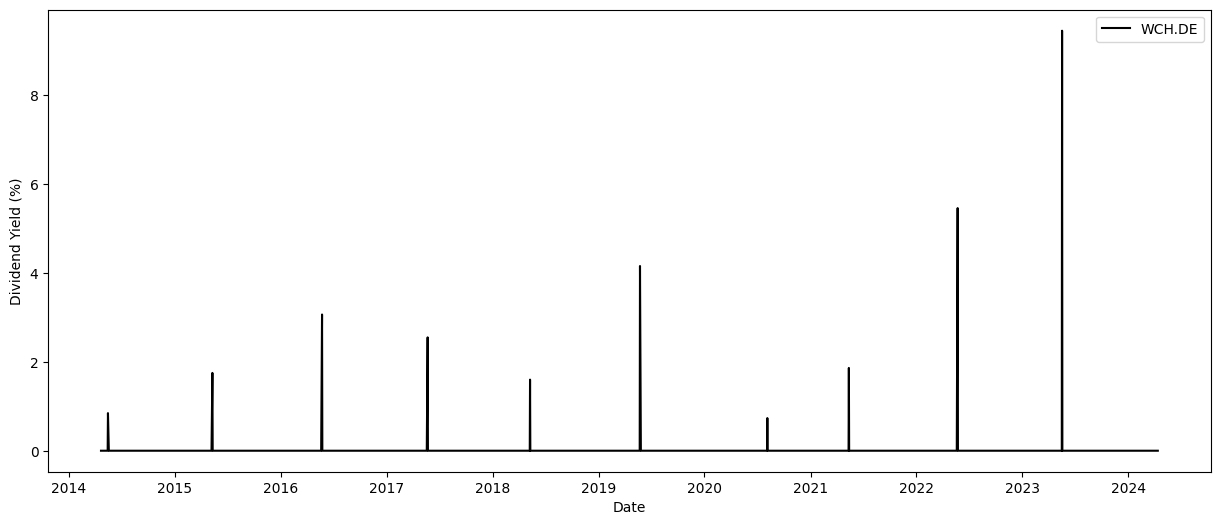

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.15097
share_price      1.00000
Name: share_price, dtype: float64


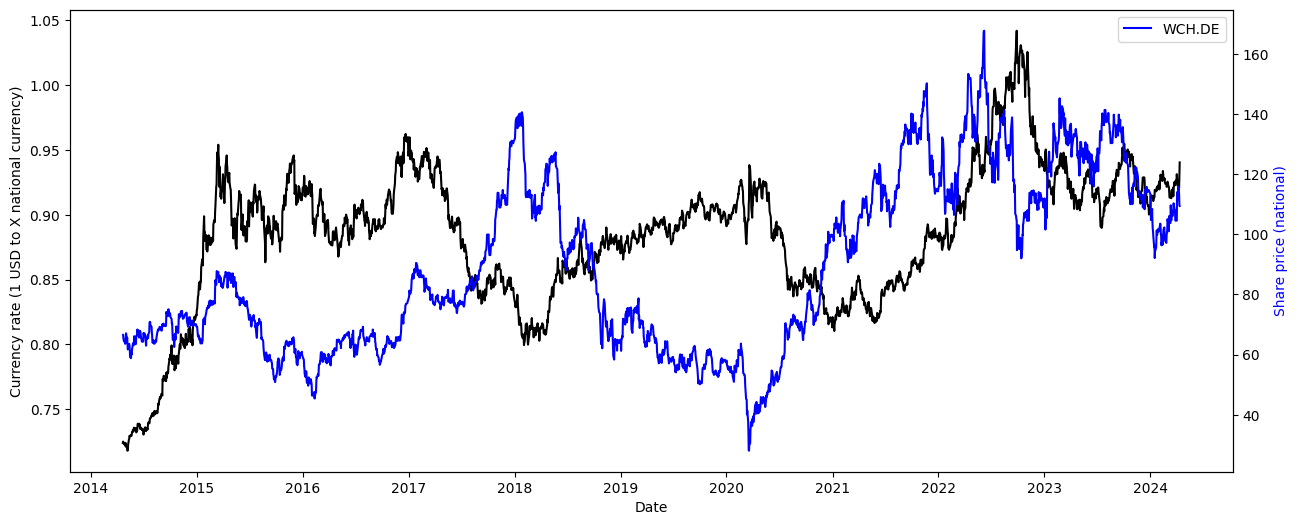

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

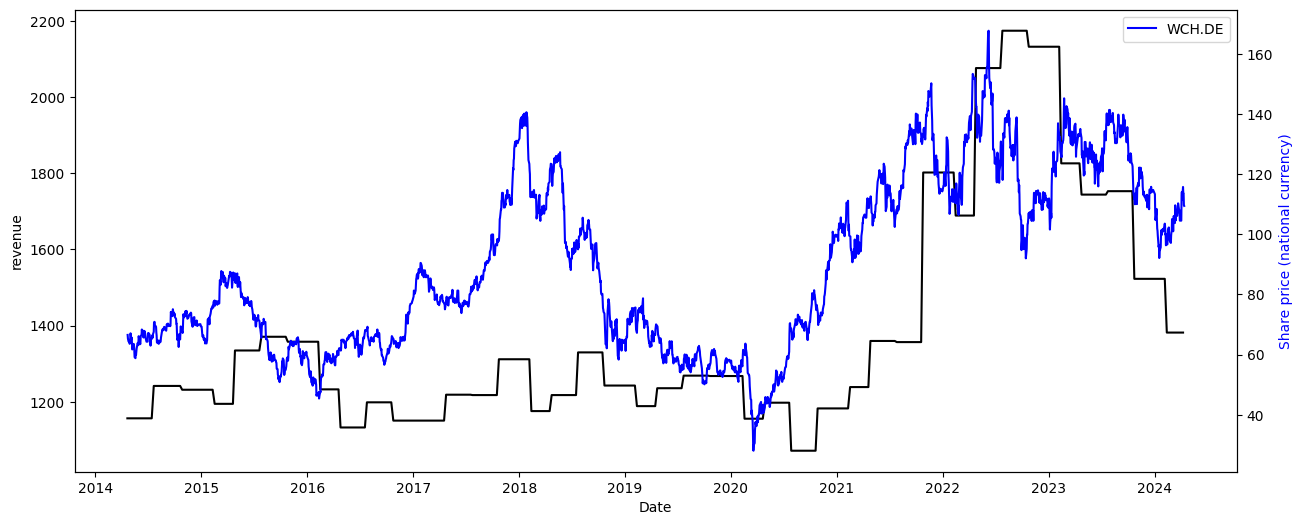

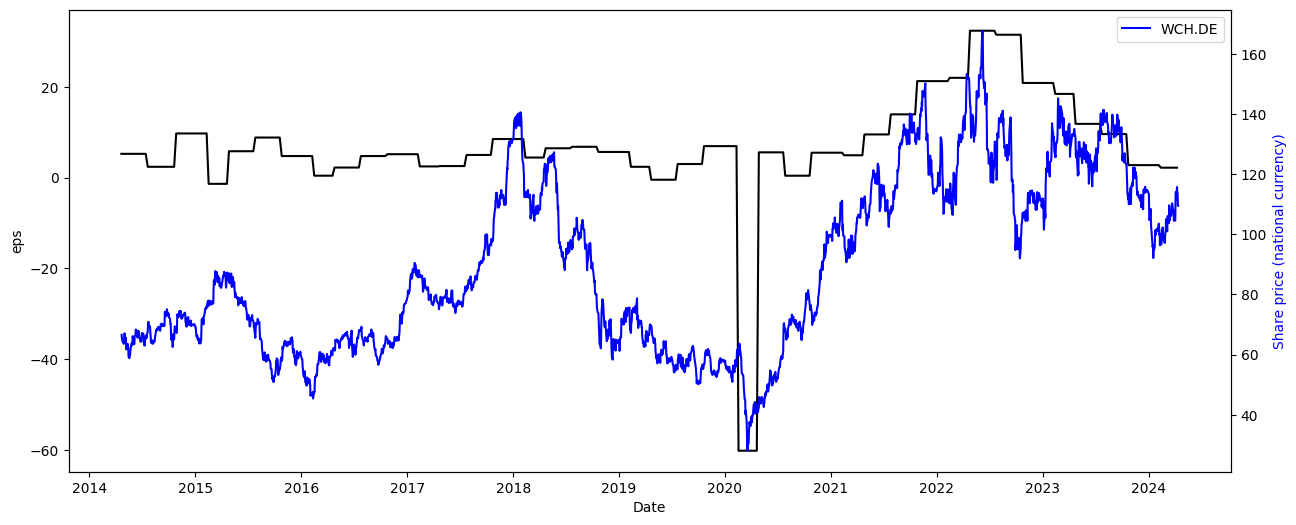

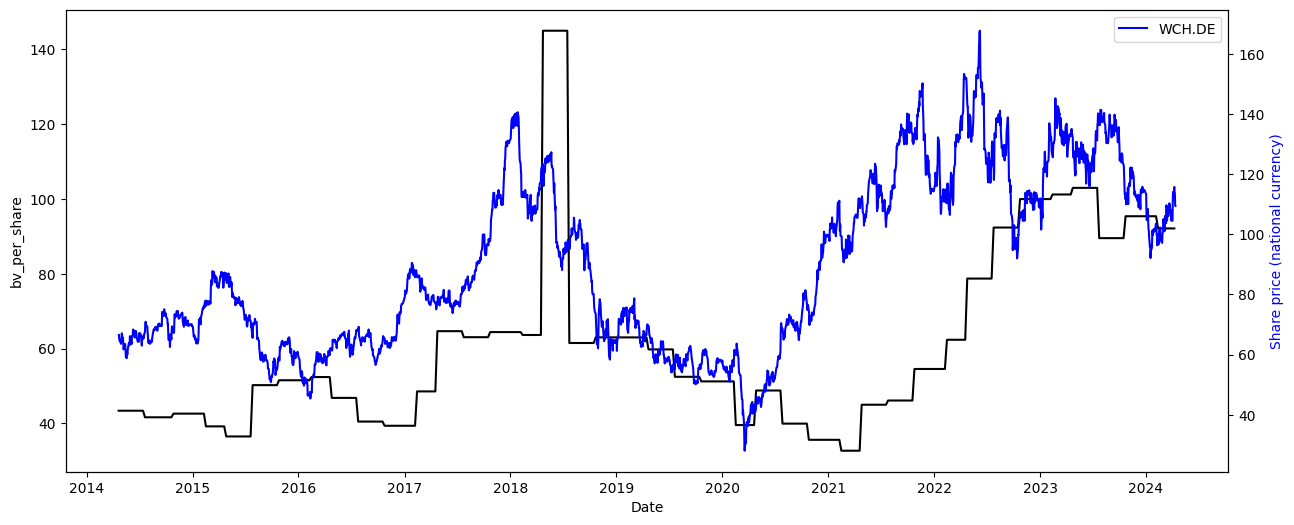

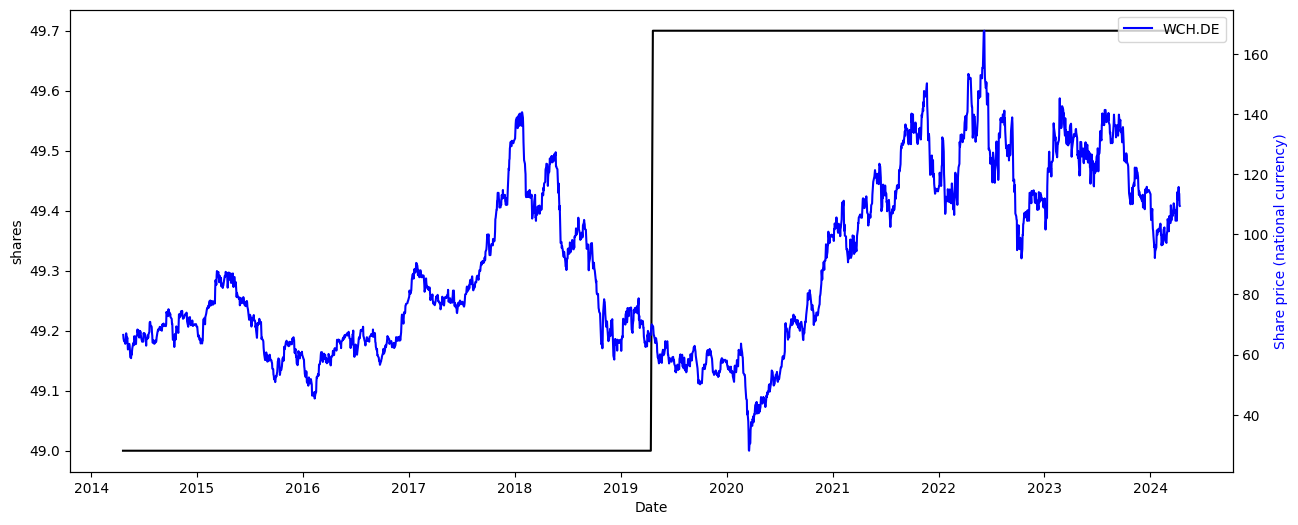

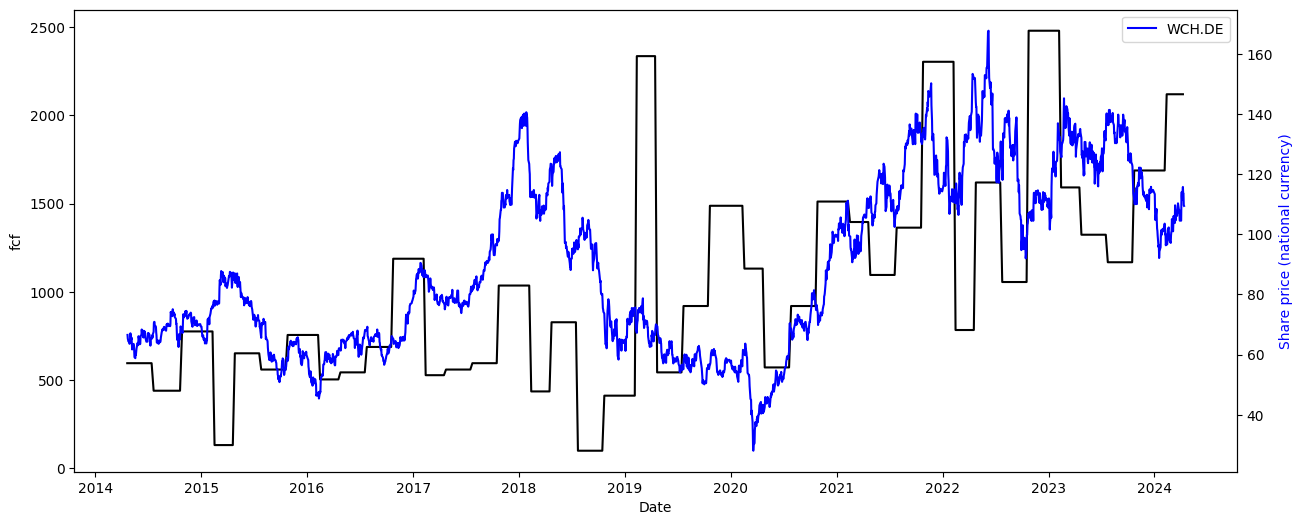

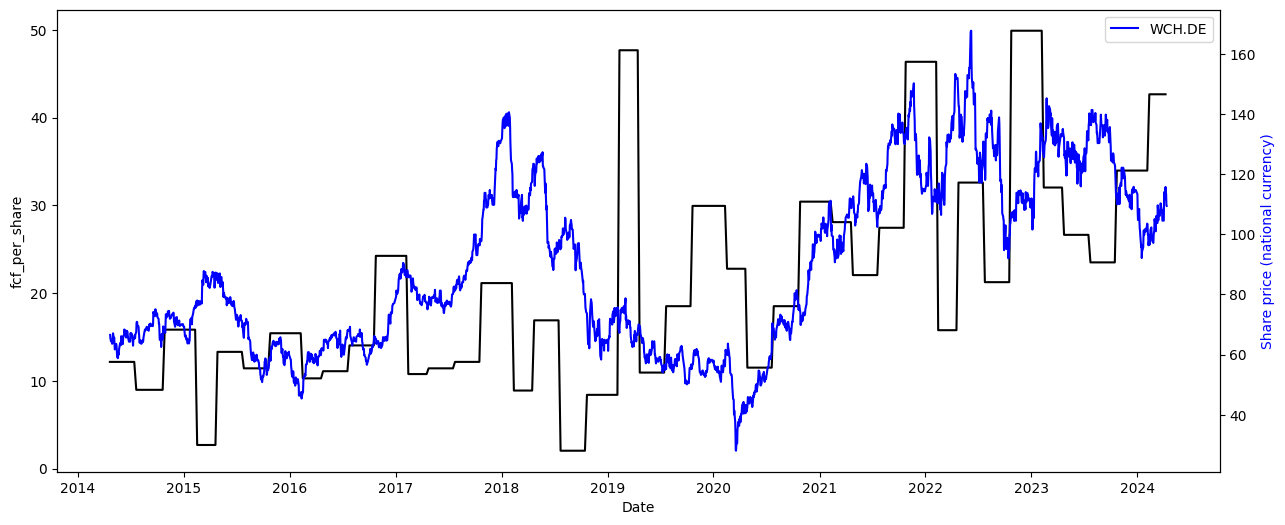

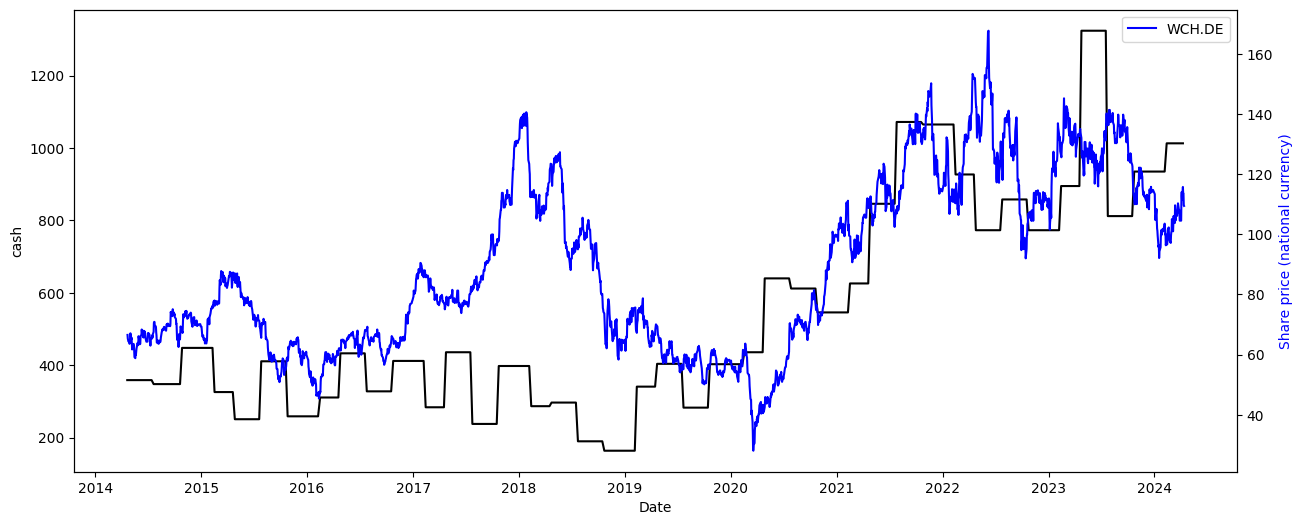

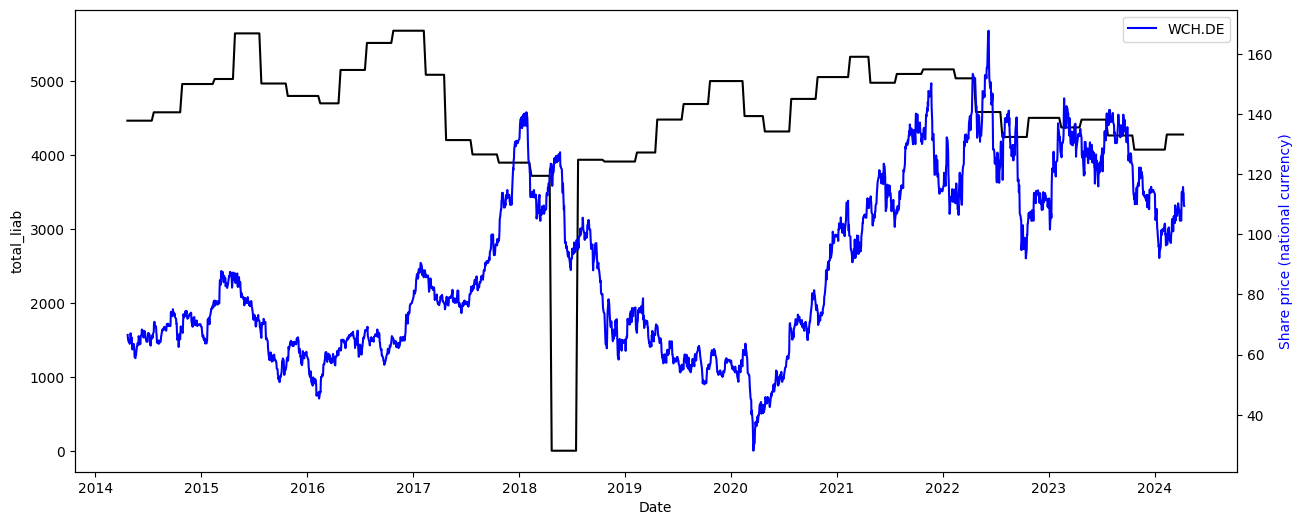

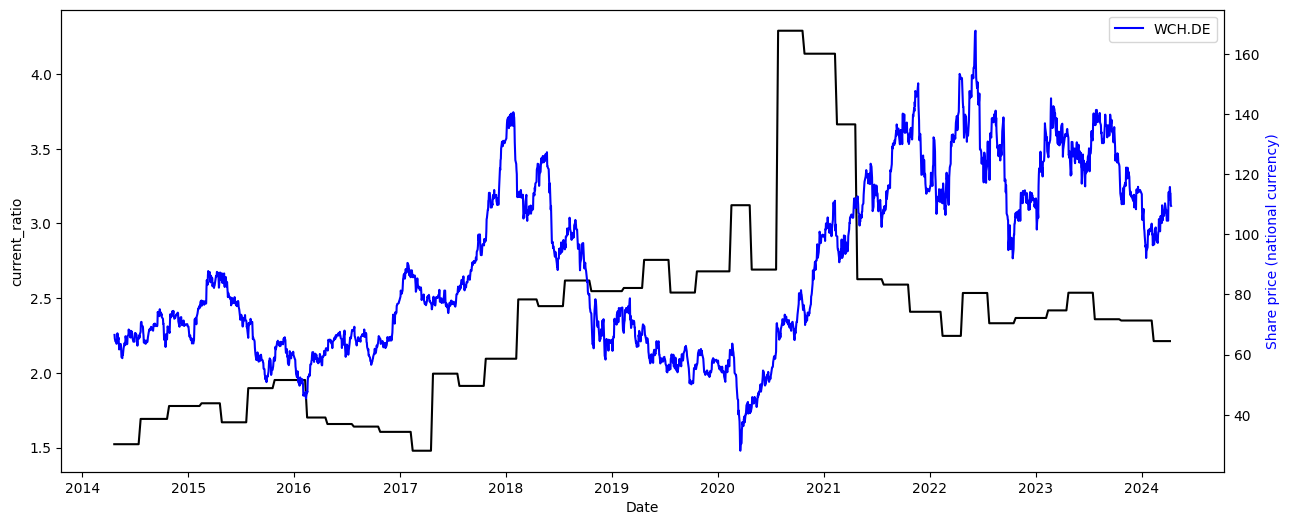

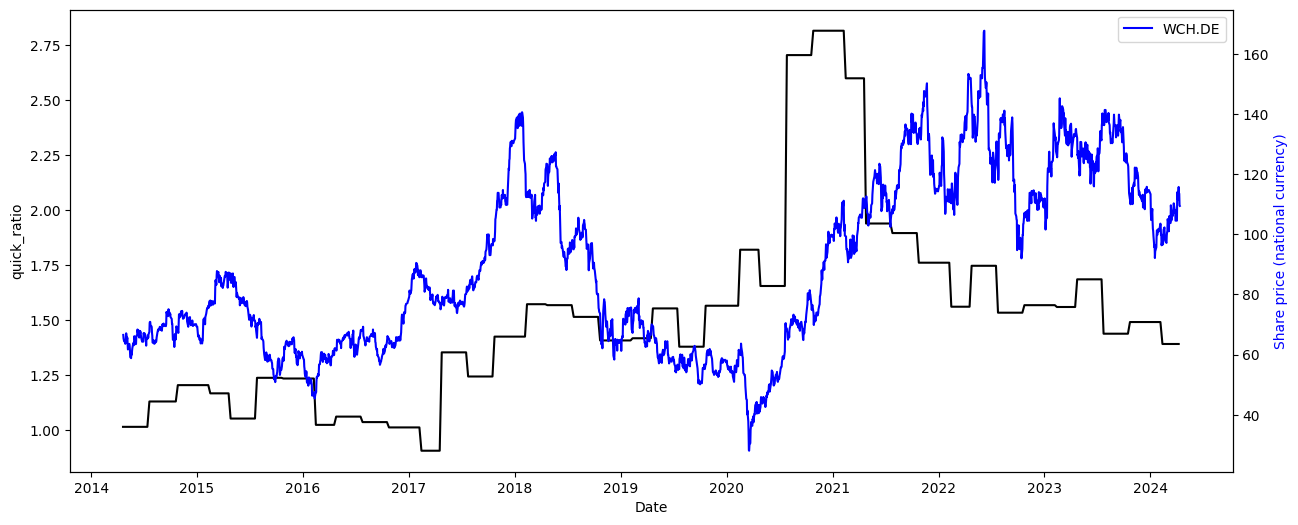

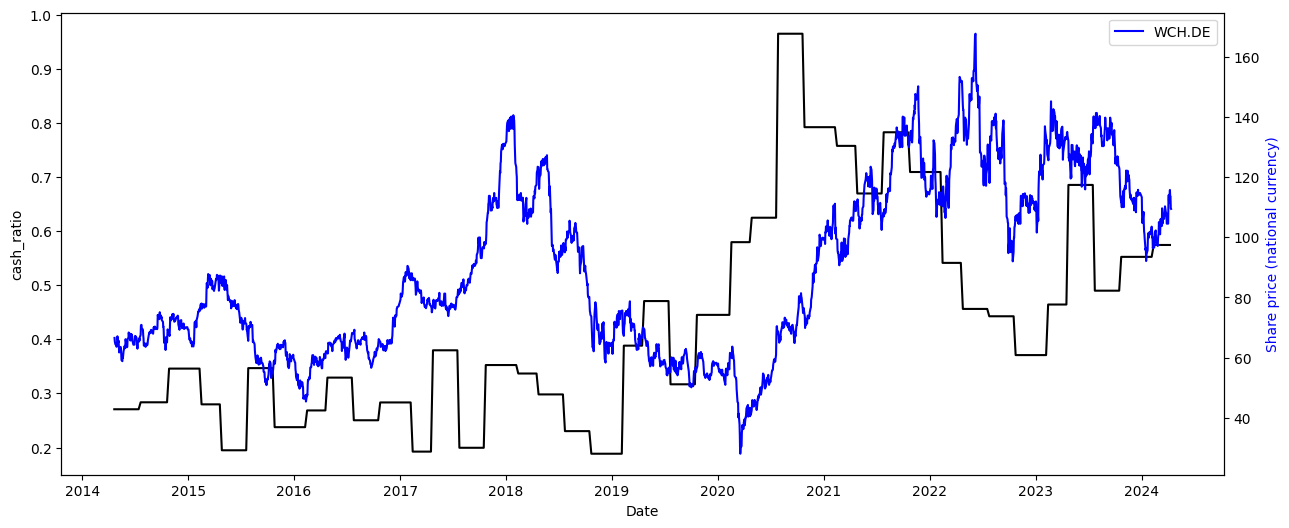

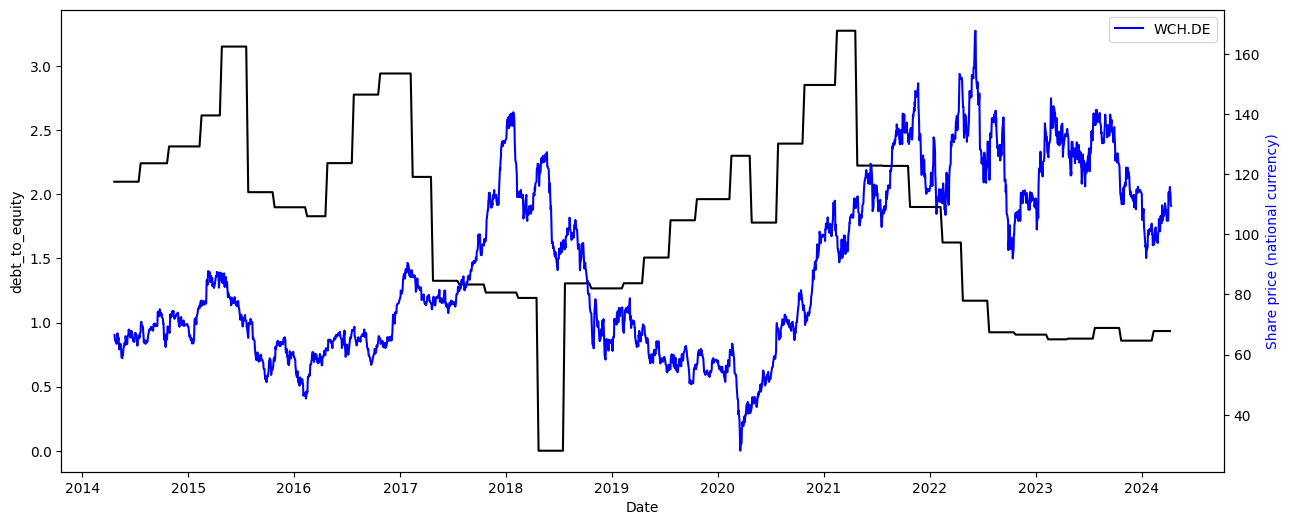

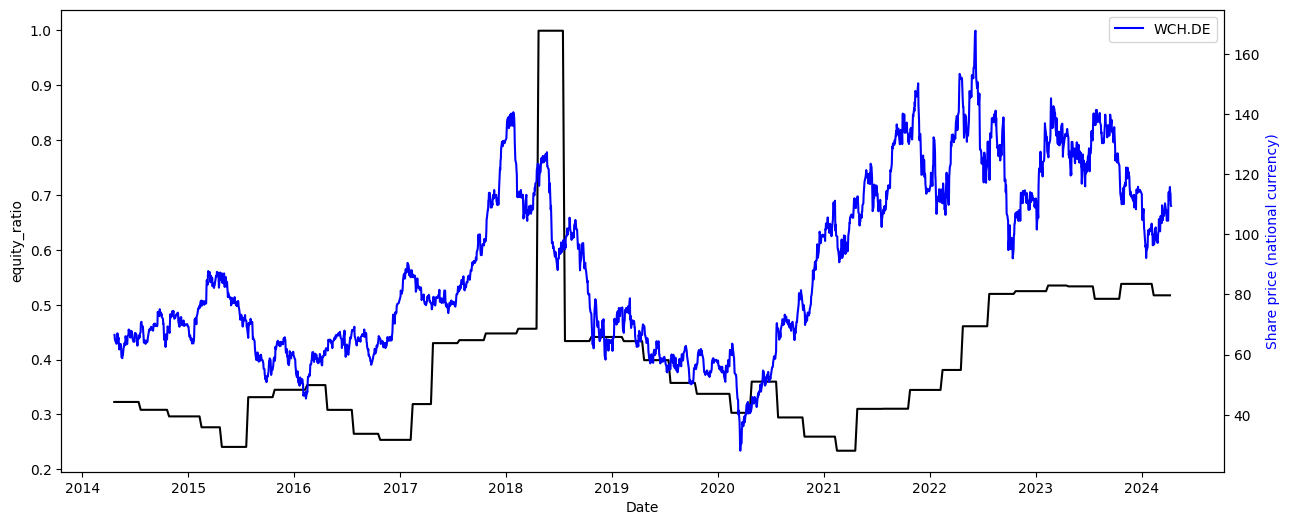

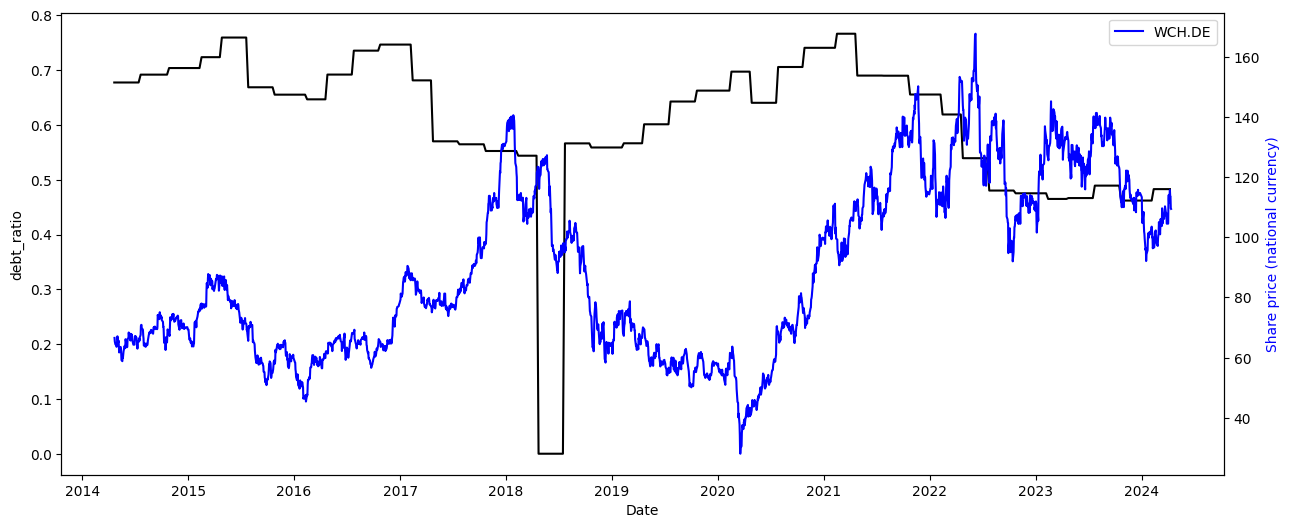

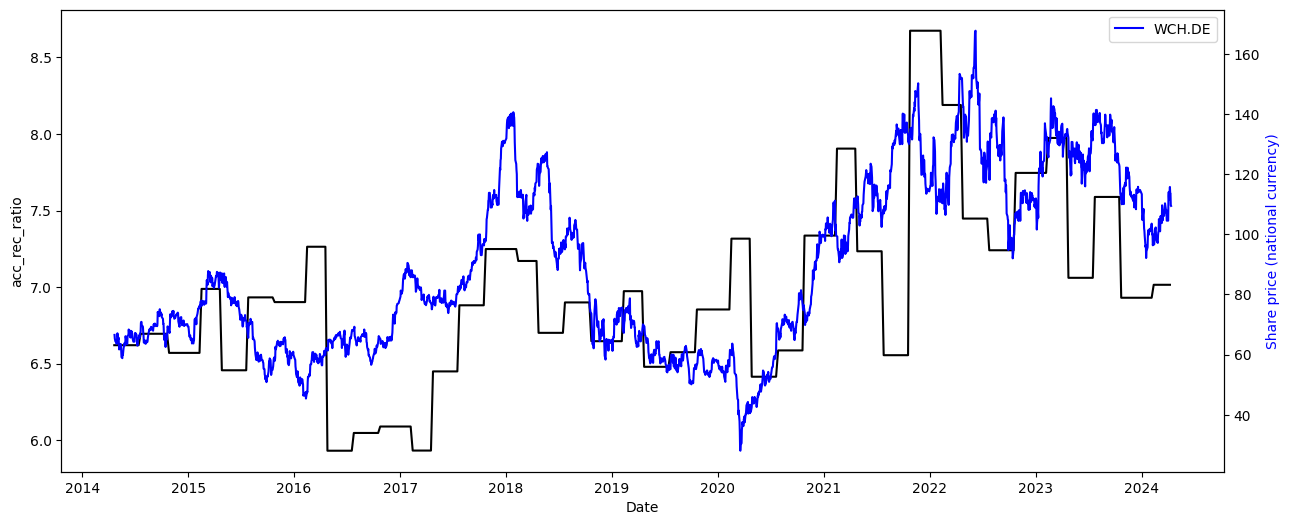

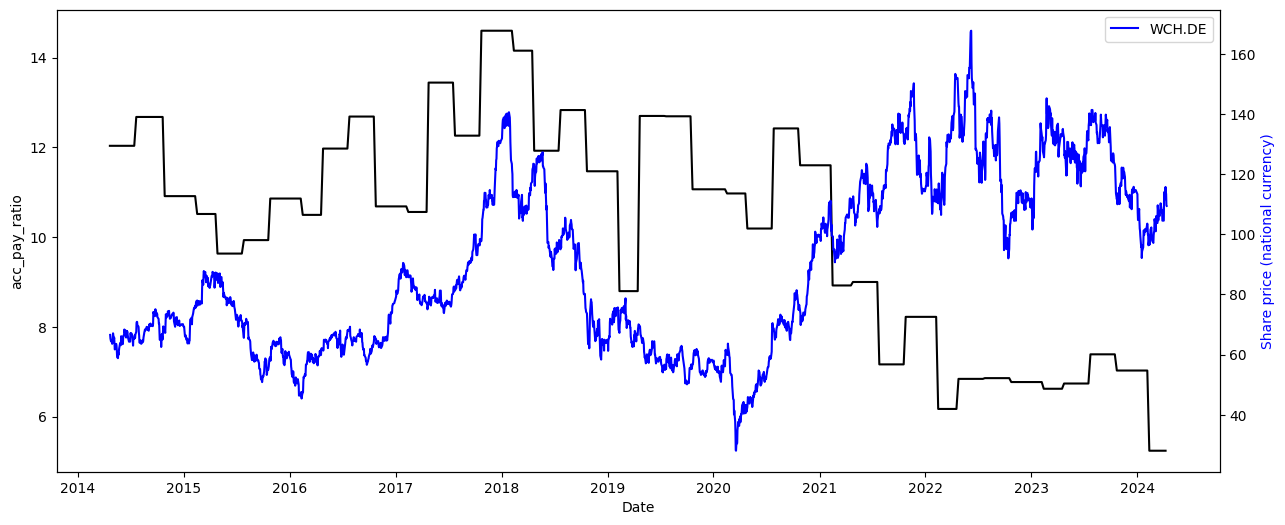

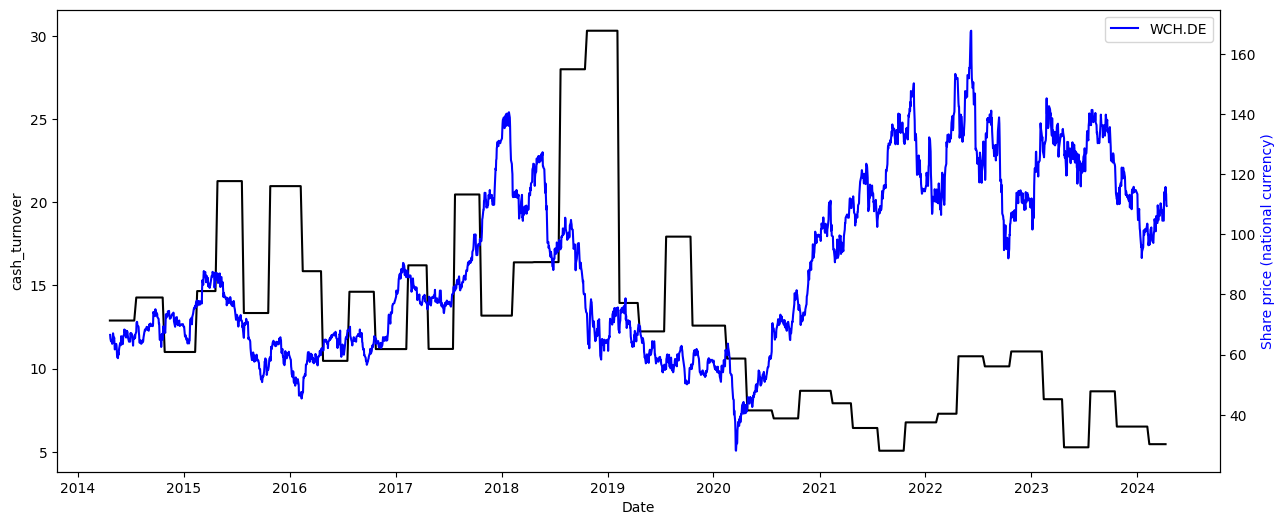

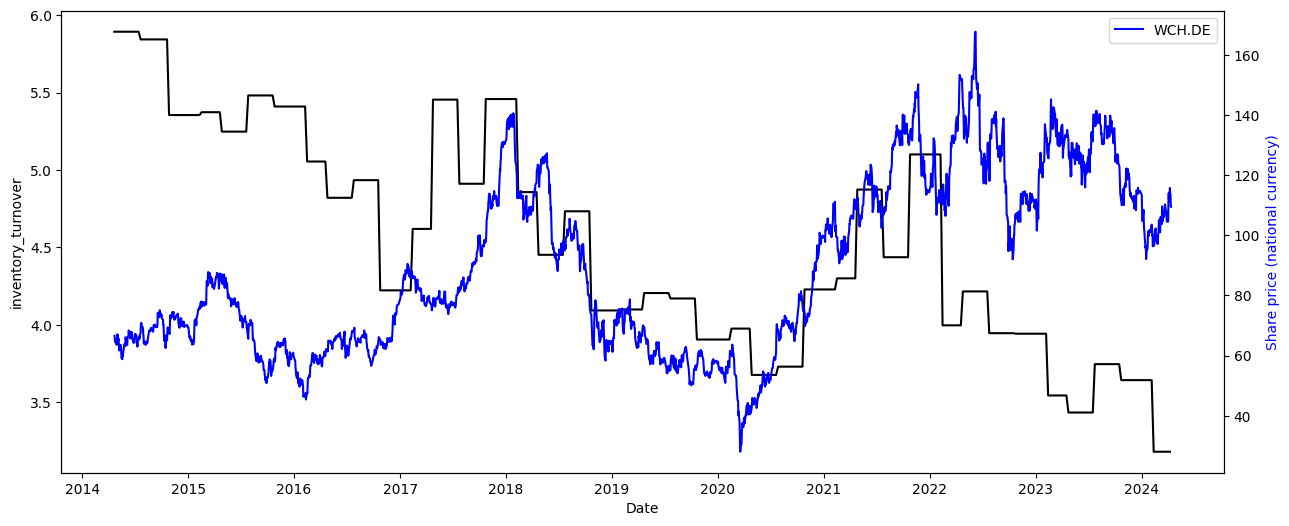

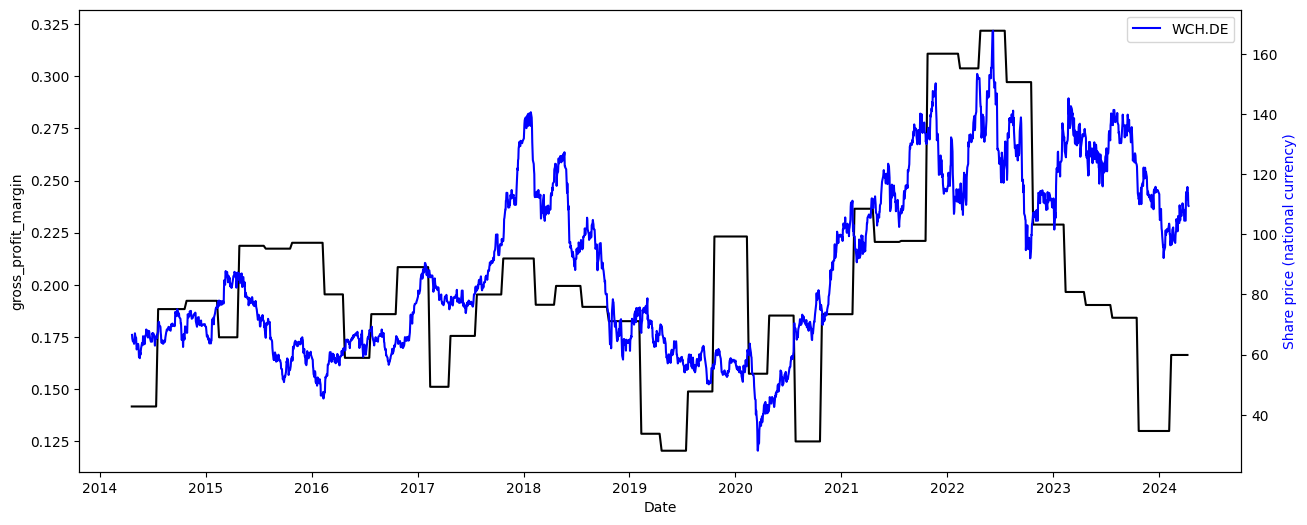

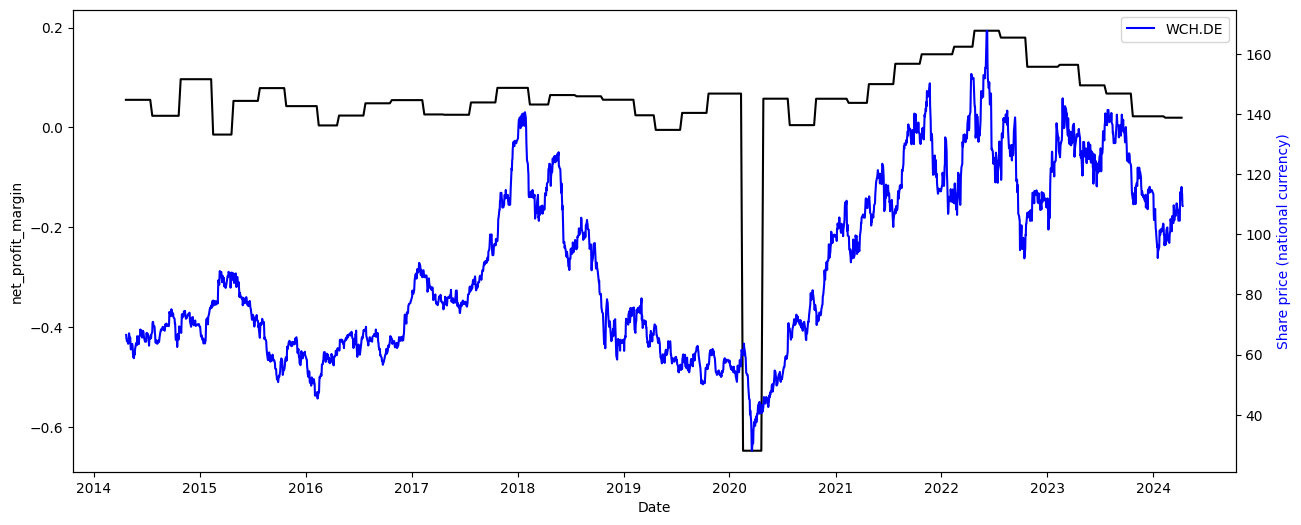

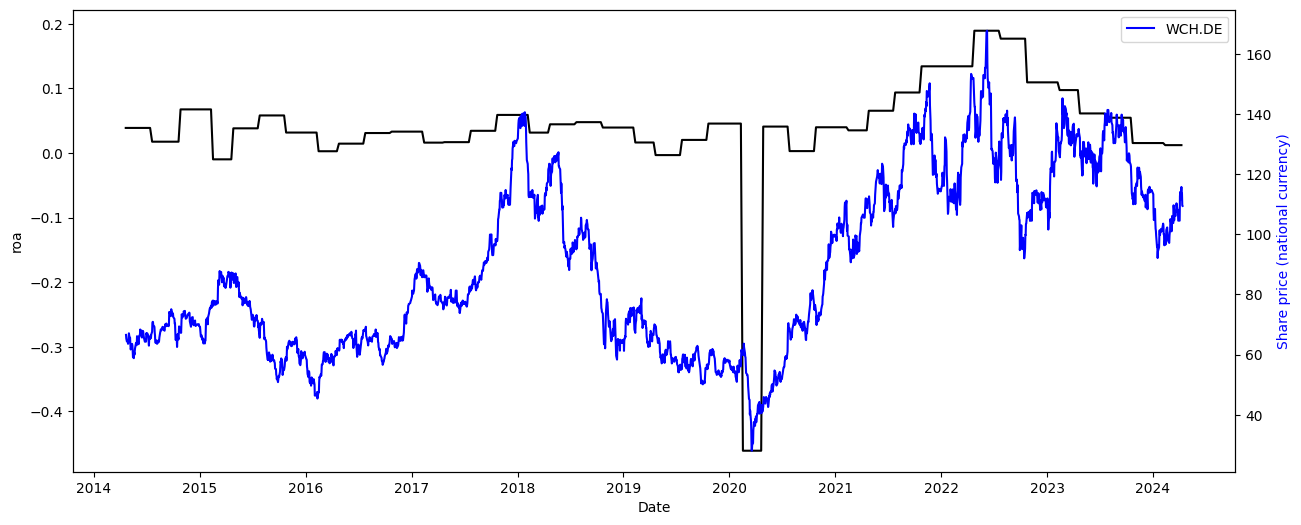

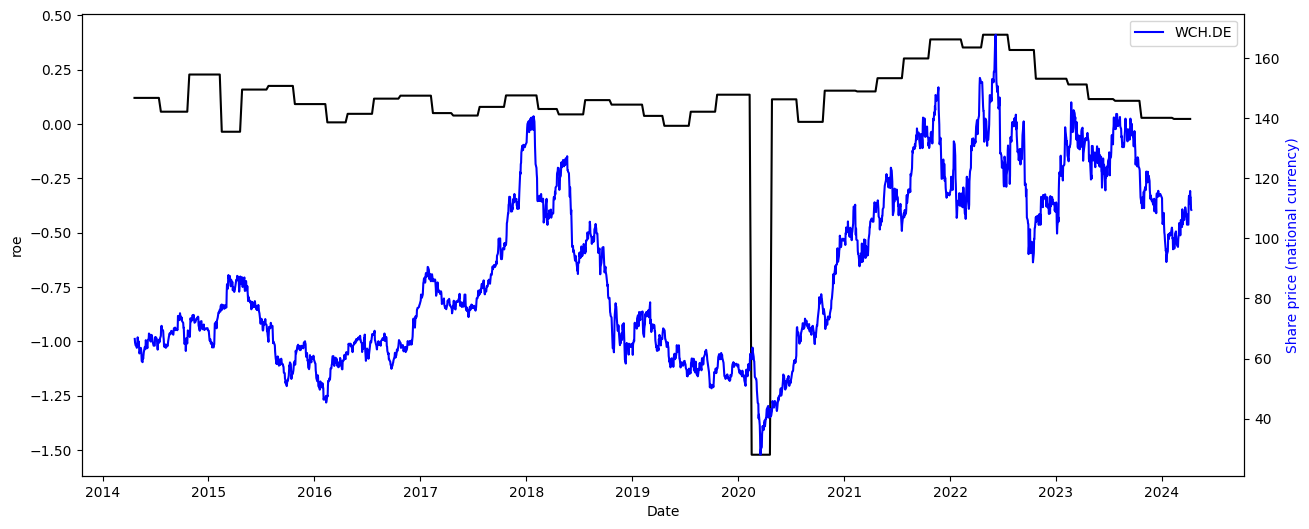

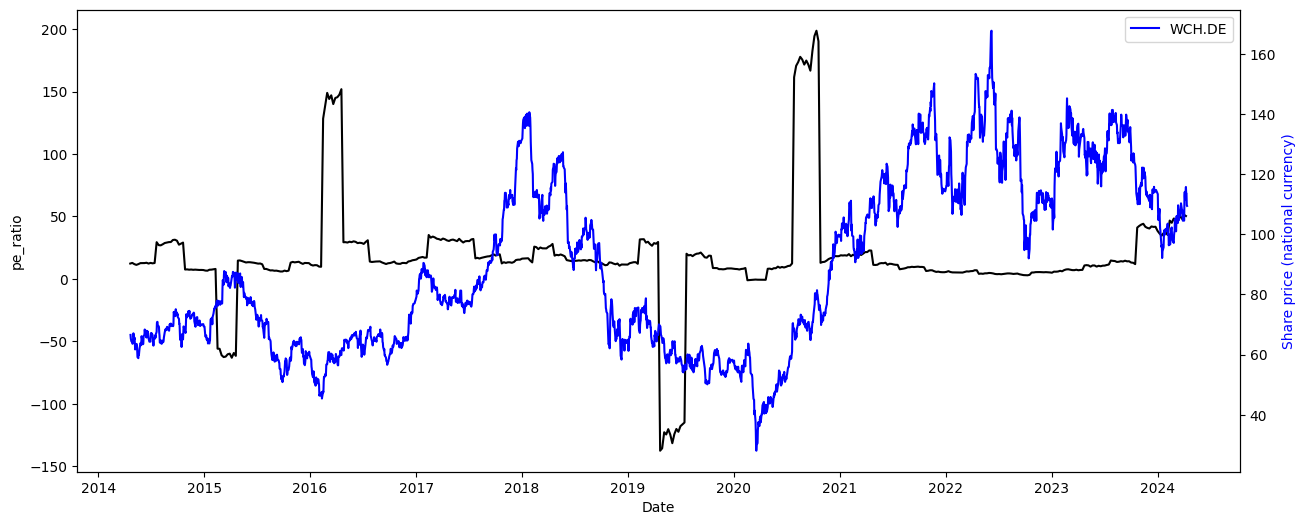

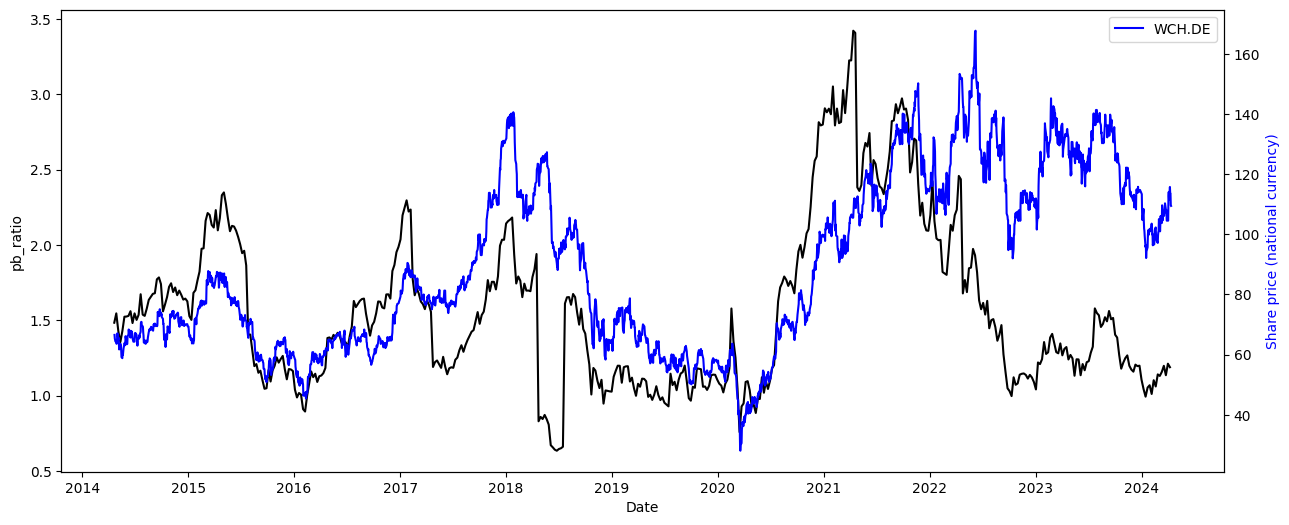

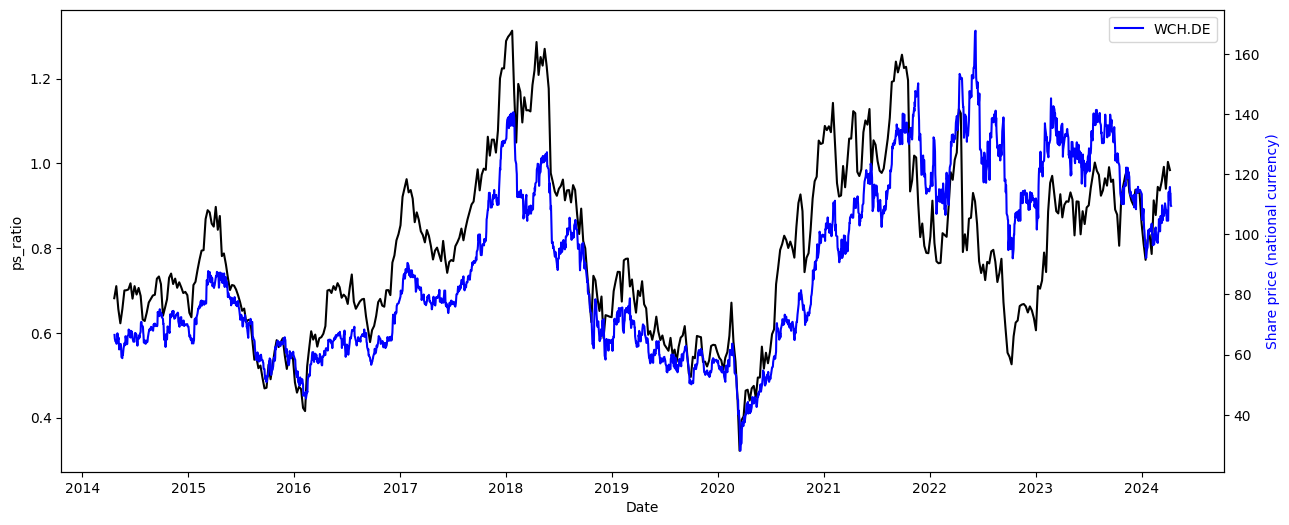

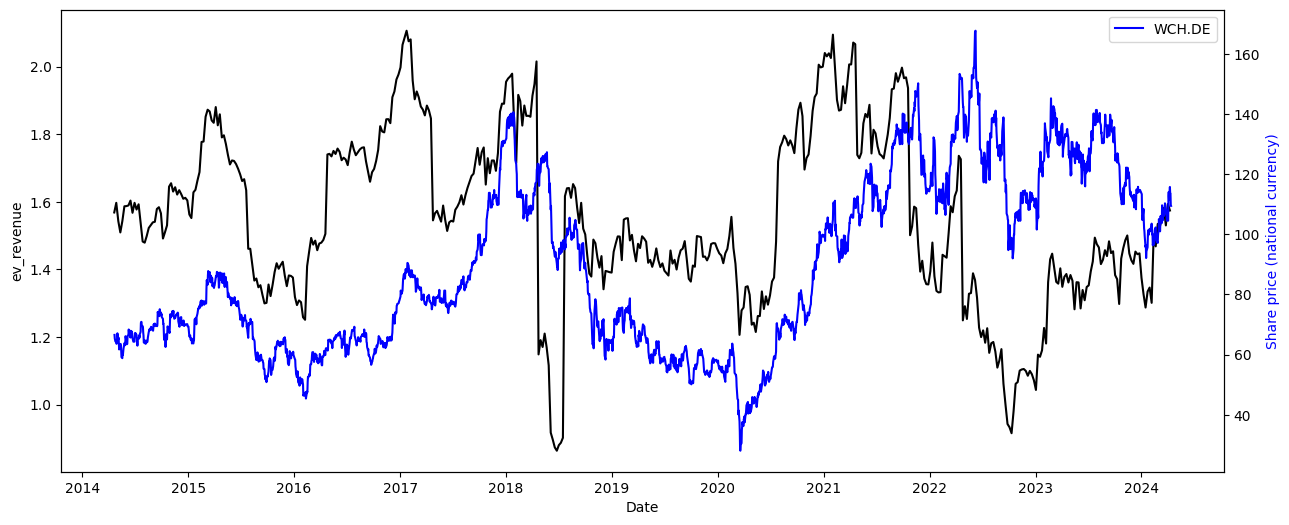

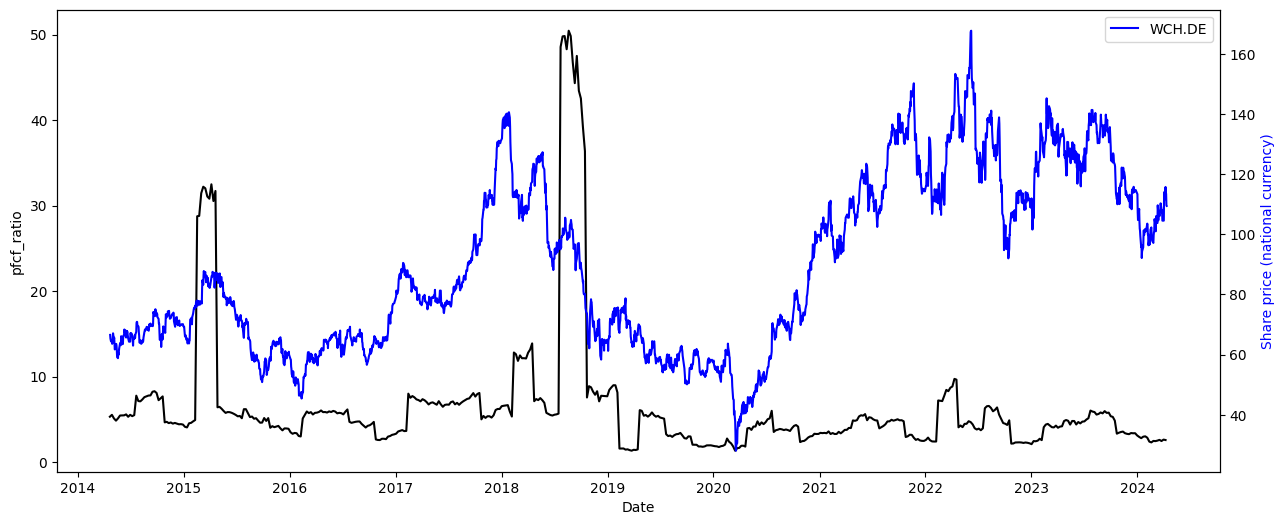

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

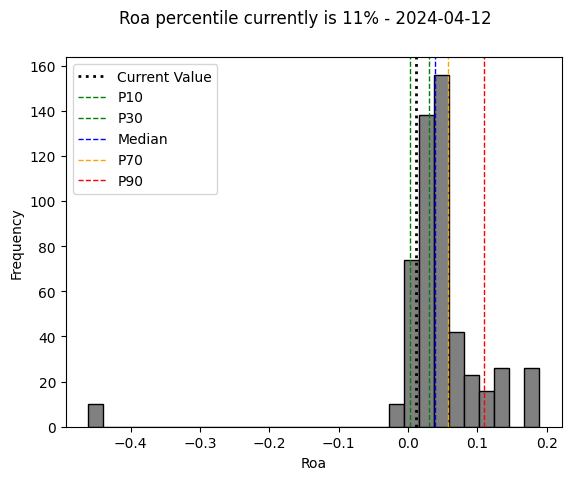

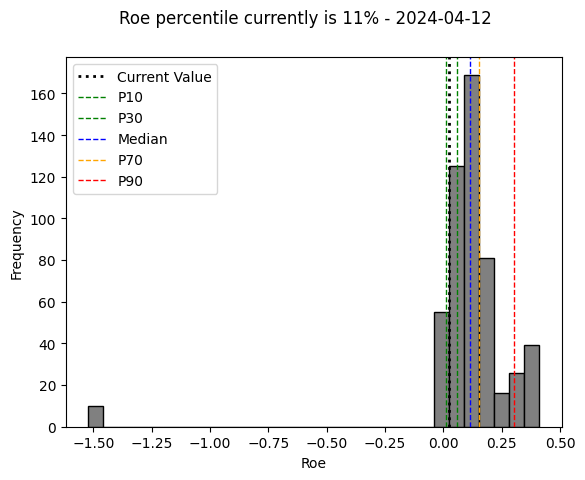

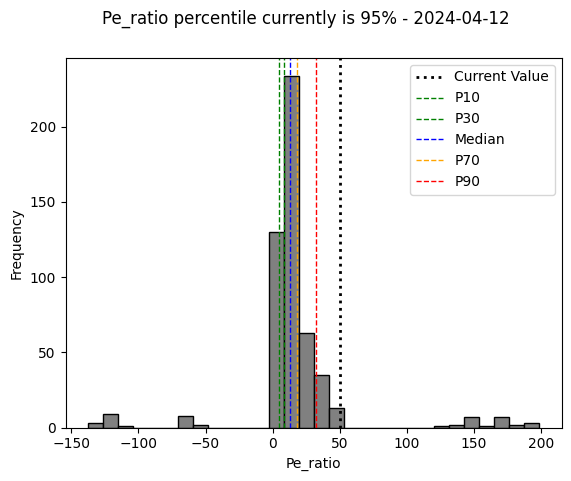

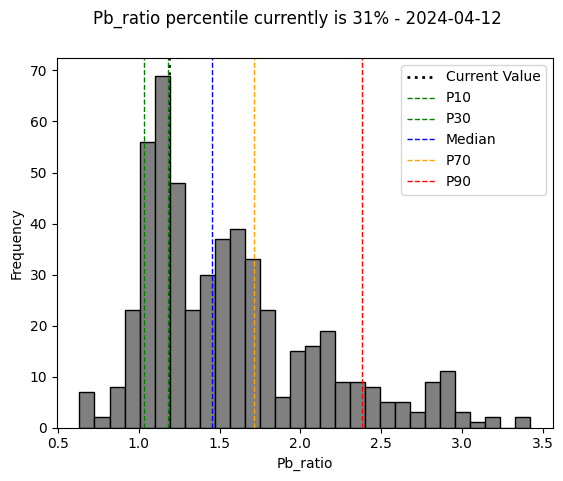

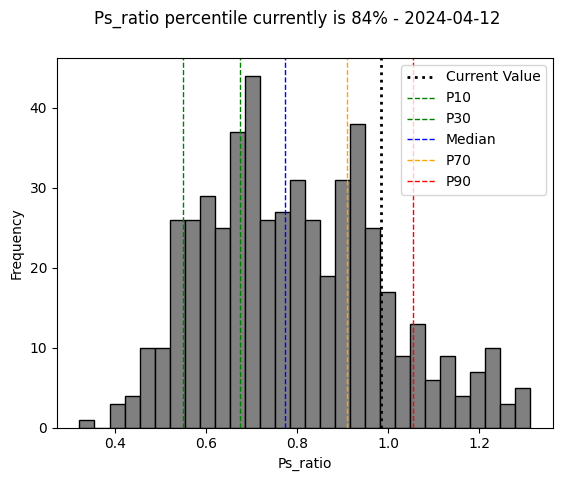

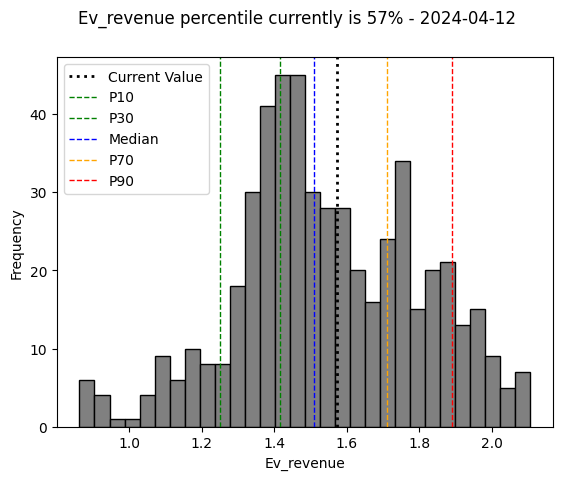

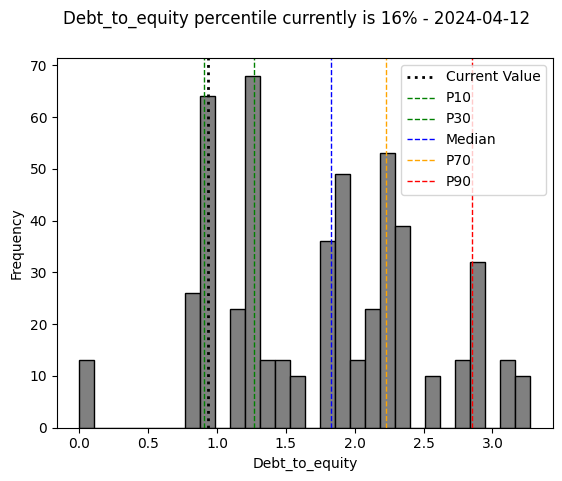

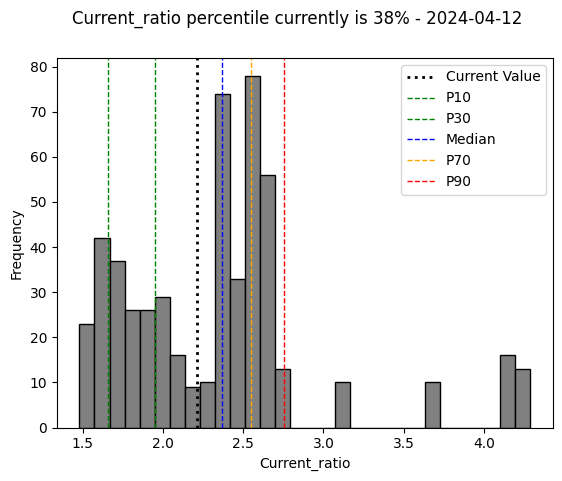

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.977274,-0.037192,0.201969,0.265349,-0.108166,-0.226254,-0.120918
roe,0.977274,1.000000,-0.014873,0.279065,0.264475,0.033385,-0.080781,-0.136084
pe_ratio,-0.037192,-0.014873,1.000000,0.023386,0.082835,0.148479,0.056823,0.188251
pb_ratio,0.201969,0.279065,0.023386,1.000000,0.592371,0.733283,0.585311,0.244275
ps_ratio,0.265349,0.264475,0.082835,0.592371,1.000000,0.476200,-0.183880,0.198974
ev_revenue,-0.108166,0.033385,0.148479,0.733283,0.476200,1.000000,0.661168,0.054494
debt_to_equity,-0.226254,-0.080781,0.056823,0.585311,-0.183880,0.661168,1.000000,0.026624
current_ratio,-0.120918,-0.136084,0.188251,0.244275,0.198974,0.054494,0.026624,1.000000


9 timestemos have been found!


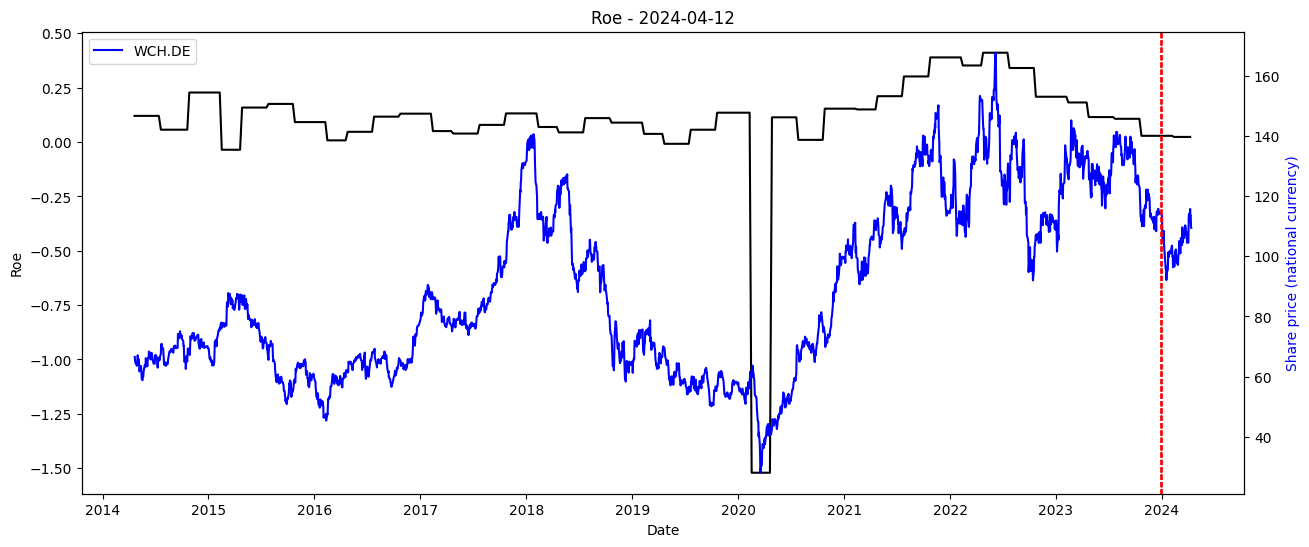

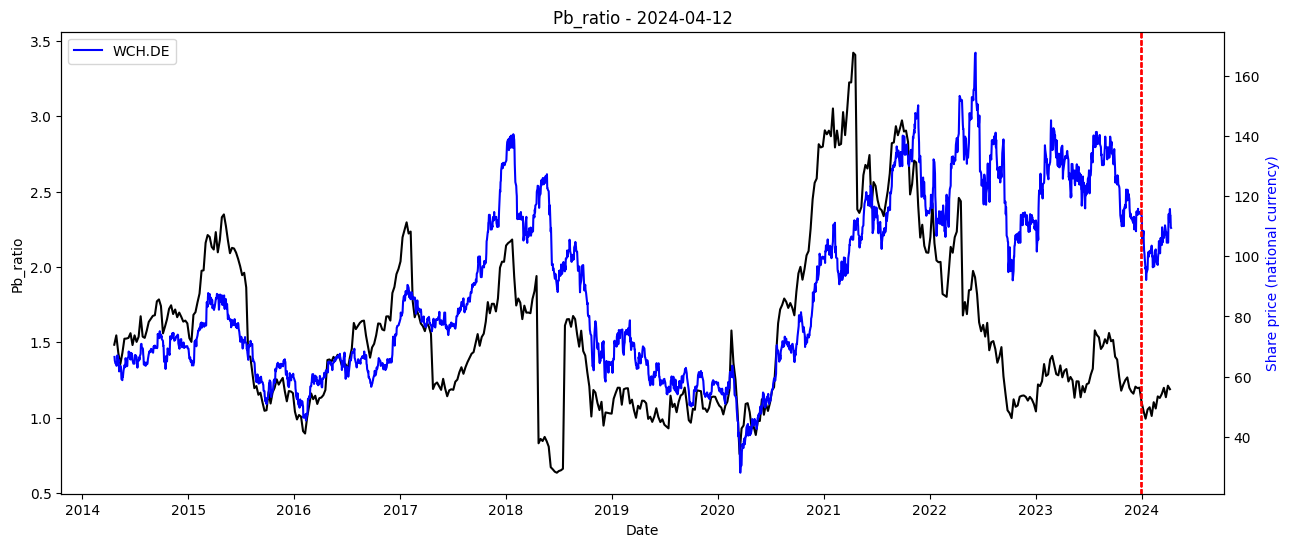

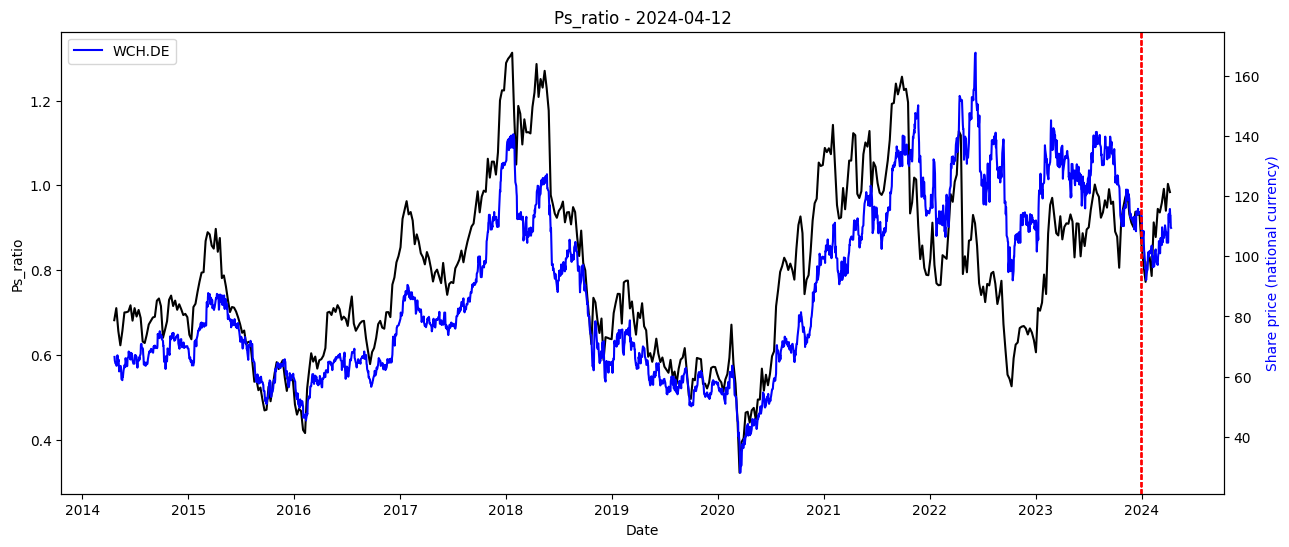

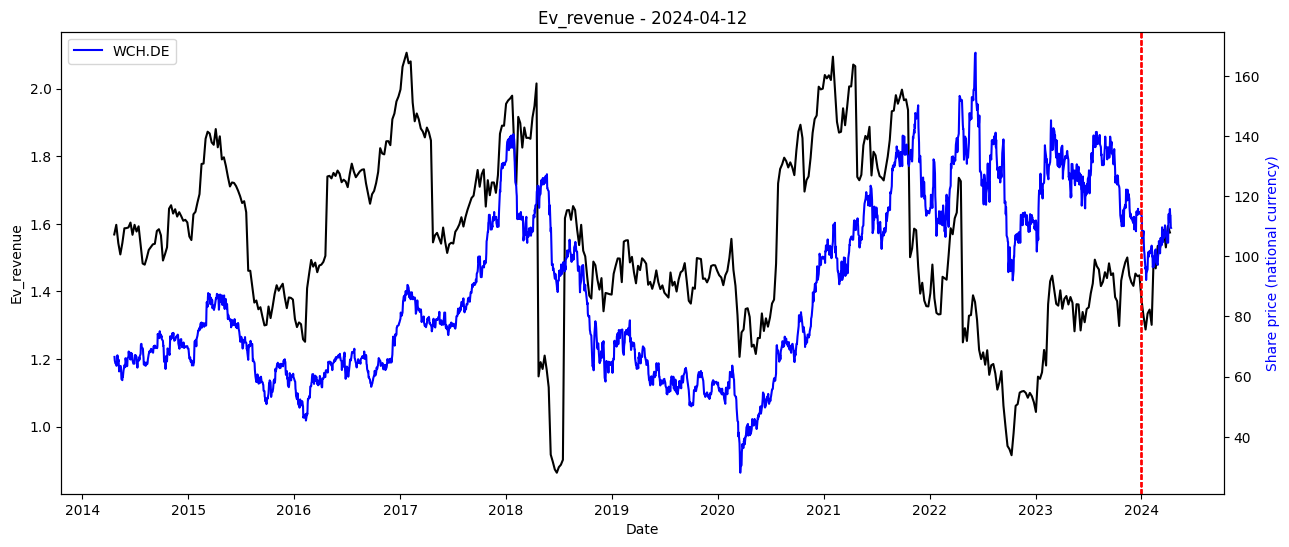

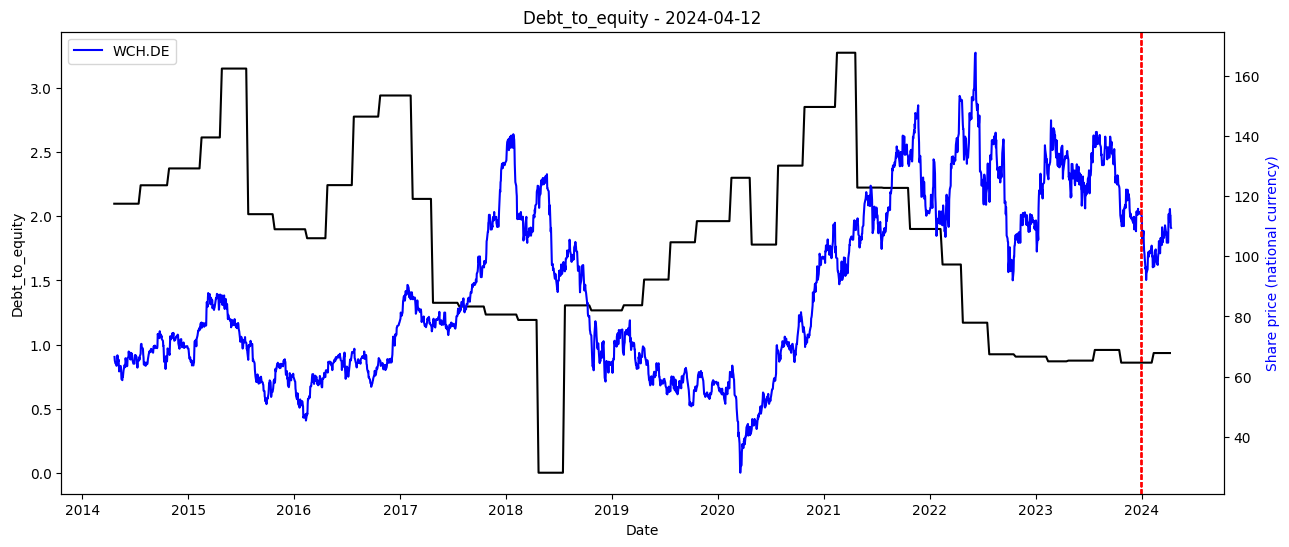

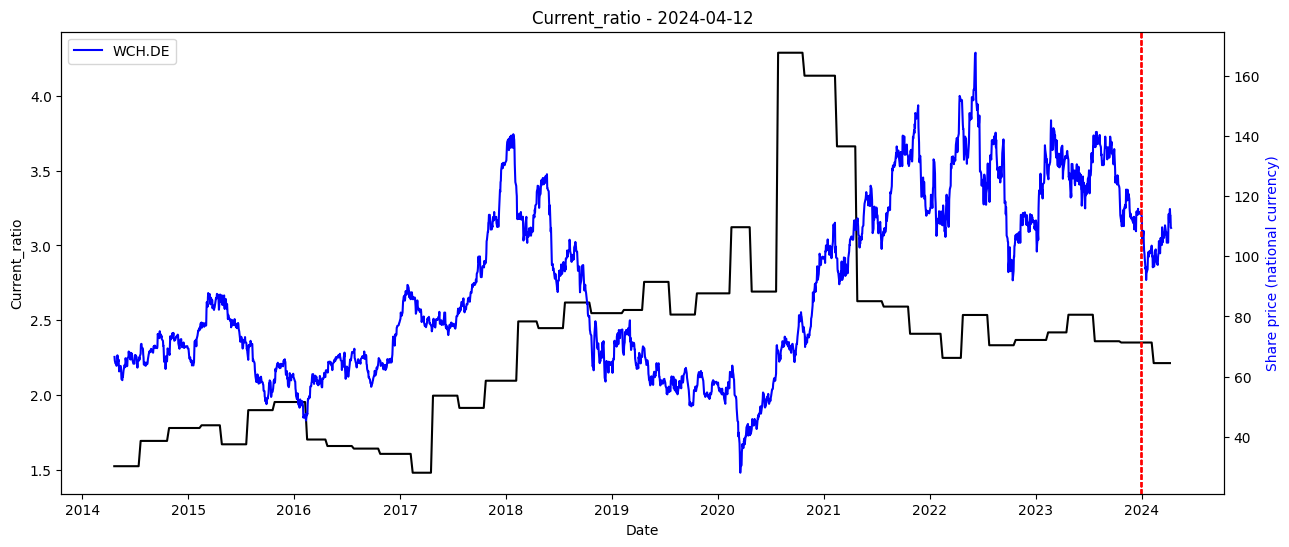

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )